# MSA 2023 Phase 2 - Part 2

In [85]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load and split preprocessed data

In [86]:
#Loading in the raw preprocessed data and will use a 70:30 split as instructed
from sklearn.model_selection import train_test_split
full_dataset = "changed_credit_scores.csv"
TARGET = "class"
full_dataframe = pd.read_csv(full_dataset,index_col=[0])
y_data = np.array(full_dataframe[TARGET].copy())
x_data = full_dataframe.copy()
x_data.drop(TARGET,axis=1,inplace=True)
x_data = np.array(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data, test_size = 0.30, random_state=101,stratify=y_data)

In [99]:
full_dataframe.head

<bound method NDFrame.head of      checking_status  duration  credit_history  purpose  credit_amount  \
0                  1       6.0               1        6         1169.0   
1                  0      48.0               3        6         5951.0   
2                  3      12.0               1        2         2096.0   
3                  1      42.0               3        3         7882.0   
4                  1      24.0               2        4         4870.0   
..               ...       ...             ...      ...            ...   
995                3      12.0               3        3         1736.0   
996                1      30.0               3        9         3857.0   
997                3      12.0               3        6          804.0   
998                1      45.0               3        6         1845.0   
999                0      45.0               1        9         4576.0   

     savings_status  personal_status   age  class  
0                 4          

## Choose a main algorithm and secondary models

In [88]:
#I will choose logistic regression as my main model and use SVC and KNN  to evaluate performance.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


logistic_regression = LogisticRegression(max_iter=200)
gnb = GaussianNB()
knn = KNeighborsClassifier()
basic_models = [logistic_regression, gnb, knn]

In [89]:
#Hypertuning the Logistic regression by testing different parameters and cross validating the results from the training data.
#There are a lot of warnings because some 'penalty' values are incompatible with 'solver'
#nonetheless, the results are: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
from sklearn.model_selection import GridSearchCV

logistic_parameters = {'penalty':['elasticnet', 'l1', 'l2', None], 'C':[50, 10, 5, 1.0, 0.5, 0.1, 0.01], 'solver':['lbfgs', 'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
lr_tuning = GridSearchCV(estimator= logistic_regression, param_grid=logistic_parameters)
lr_tuning.fit(x_train,y_train)
lr_best = lr_tuning.best_estimator_
print(lr_tuning.best_params_)

c:\Users\kimby\Desktop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kimby\Desktop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kimby\Desktop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kimby\Desktop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kimby\Desktop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\kimby\Desktop\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarn

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [90]:
#Hypertuning the 'n_neighbors' and 'weights' parametrs using crossvalidation
#The knn_tuning.best_params_ will be kept and used for testing the model on the test dataset.
knn_parameters = {'n_neighbors':[3,5,10,15,20], 'weights':['uniform', 'distance']}
knn_tuning = GridSearchCV(estimator= knn, param_grid=knn_parameters)
knn_tuning.fit(x_train,y_train)
knn_best = lr_tuning.best_estimator_
print(knn_tuning.best_params_)

{'n_neighbors': 15, 'weights': 'uniform'}


Gaussian NB cannot be tuned except by using priors. We do not have any access to probability priors so this model will not be tuned.

## Testing the models

In [91]:
#Testing the model on the unseen test data
#Storng the predictions, confusion_matrix, classification_report for future analysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

predictions = []
cm_list = []
cr_list = []
proba = []
for v in range(len(models)):
    model = models[v]
    if model == logistic_regression:
        model.set_params(**lr_tuning.best_params_)
    elif model == knn:
        model.set_params(**knn_tuning.best_params_)
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    predictions.append(prediction)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    proba.append(y_pred_proba)
    cm = confusion_matrix(y_test, prediction)
    cr = classification_report(y_test, prediction)
    cm_list.append(cm)
    cr_list.append(cr)



## Model Evaluation

LogisticRegression()
True Positives: 198, False Postives: 75, True Negatives: 15, False Negatives 12



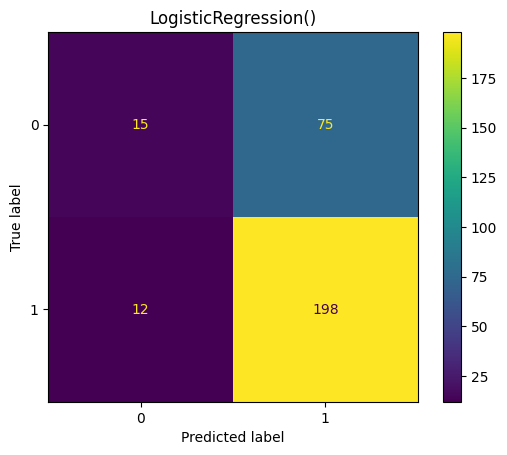

GaussianNB()
True Positives: 199, False Postives: 60, True Negatives: 30, False Negatives 11



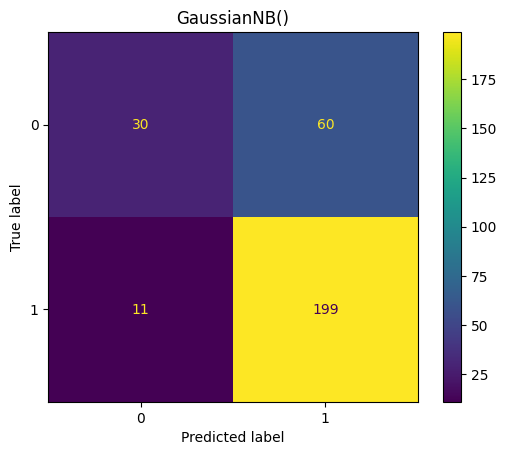

KNeighborsClassifier()
True Positives: 166, False Postives: 70, True Negatives: 20, False Negatives 44



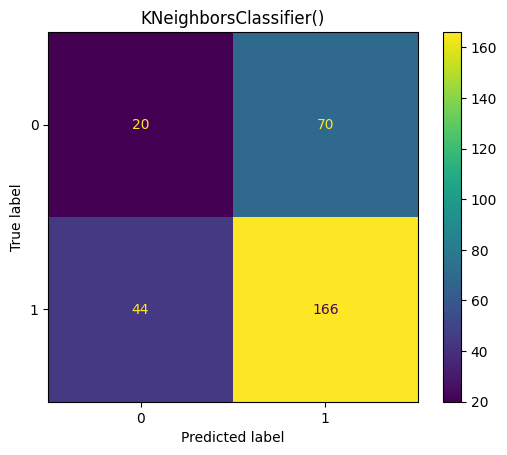

In [92]:
#Obtaining the True Positives, False Postives, True Negatives, False Negative metrics for each model.
#The true positive show the number of predicted postivies that were actual positives,the true negatives show the number of predicted negataives that ware actually negative.
#The False positive show the number of predicted postivies that were actually negative,the False negatives show the number of predicted negataives that ware actually Positive.
#The most noticeable metrics from this analysis is the FN count being higher than the TN count for some models. This means that model was poor at classifying the negative class.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
for q in range(len(models)):
    model = models[q]
    cm = cm_list[q]
    tn, fp, fn, tp = cm.ravel()
    print(model)
    print('True Positives: {}, False Postives: {}, True Negatives: {}, False Negatives {}'.format(tp,fp,tn,fn))
    print()


    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.title(model)
    plt.show()

In [97]:
# recall is the rate of actual positive instances among all instances are actually positive  (TP / (TP + FN)
# Precision is the rate of actual positive instances among all instances that were predicted to be positive (TP / (TP + FP))
# Recall and precision are used to calculate the f1 score, which gives a greater understanding of model performance than ordinary accuracy.
# As noticable, the models have strong recall and f1 scores, meaning they were good at identifying positive classes (class = 'good')
for k in range(len(models)):
    print(models[k])
    print(cr_list[k])

LogisticRegression()
              precision    recall  f1-score   support

           0       0.56      0.17      0.26        90
           1       0.73      0.94      0.82       210

    accuracy                           0.71       300
   macro avg       0.64      0.55      0.54       300
weighted avg       0.67      0.71      0.65       300

GaussianNB()
              precision    recall  f1-score   support

           0       0.73      0.33      0.46        90
           1       0.77      0.95      0.85       210

    accuracy                           0.76       300
   macro avg       0.75      0.64      0.65       300
weighted avg       0.76      0.76      0.73       300

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.31      0.22      0.26        90
           1       0.70      0.79      0.74       210

    accuracy                           0.62       300
   macro avg       0.51      0.51      0.50       300
weighted avg     

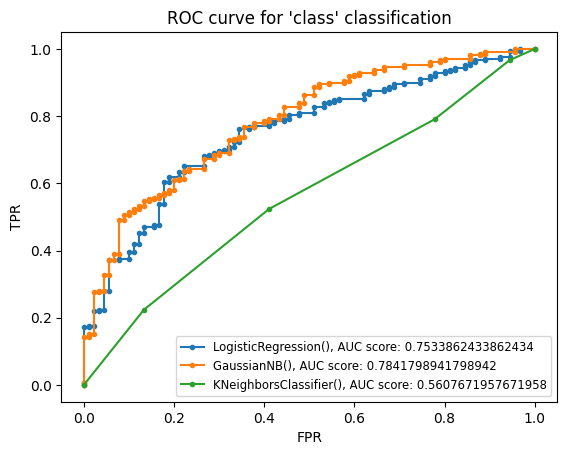

In [94]:
#Displaying the performance metrics in the form of a ROC curve, which shows the performance of a binary classifier in respect to the TPR and FPR.
#The graph being closer to the top left corner indicates a perfect binary classifier 
#The AUC is a metric which is the Area under Curve in the ROC. The higher the valuem, the better the classifier.
#Clearly, the Logistic Regression and GaussianNB were better performing than the KNN model.
from sklearn.metrics import roc_curve, roc_auc_score
legend = []
for i in range(len(models)):
    model = models[i]
    prediction = predictions[i]
    fpr, tpr, threshold = roc_curve(y_test, proba[i])
    auc = roc_auc_score(y_test, proba[i])
    legend_string = "{}, AUC score: {}".format(str(model),auc)
    legend.append(legend_string)
    plt.plot(fpr,tpr, marker='.')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC curve for 'class' classification")
plt.legend(legend, fontsize='small')

## 5. Summary